# Notebook Instructions

1. All the <u>code and data files</u> used in this course are available in the downloadable unit of the <u>last section of this course</u>.
2. You can run the notebook document sequentially (one cell at a time) by pressing **shift + enter**. 
3. While a cell is running, a [*] is shown on the left. After the cell is run, the output will appear on the next line.

This course is based on specific versions of python packages. You can find the details of the packages in <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank" >this manual</a>.

# Long-only momentum strategy

In this notebook, we will create and backtest a long-only momentum strategy using the quant strategy framework discussed in the previous video unit.

The basic building blocks of the strategy are:

<B>1. Universe Selection <BR></b>
We have defined a static list of 10 cryptocurrencies which will form the universe for this strategy. The selection criteria for the universe can be based on the market cap and the daily volume traded.  <BR><BR>

<b>2. Alpha Generation <BR></b>
We have used the following parameters to assign a score to each of the cryptocurrencies.

2.1. 2-day returns <BR>
2.2. 7-day standard deviation <BR>
2.3. 14-day relative strength index <BR>
    
The criteria and the lookback period are for illustration purpose only. It is recommended that you add more parameters and optimize the lookback period in the training dataset. <BR><BR>

<b>3. Portfolio Construction <BR></b>
Based on the combined score of all the three parameters, the portfolio is constructed. In this strategy, We go long on the top 5 cryptocurrencies.
    
Steps 2 and 3 are repeated at regular intervals such as daily to rebalance the portfolio.

# Universe Selection

In this step, select the universe of the cryptocurrency to trade with. We have selected 10 cryptocurrencies namely Bitcoin, Ripple, EOS, Stellar Lumens, Litecoins, Ethereum, Dash, Monero, Neo, and Ethereum Cash.

In [1]:
# Import pandas library and set the alias name to pd
import pandas as pd

# Read the csv data from cryptos_price.csv into a dataframe df.
# This file can be downloaded from the last section of this course.
df = pd.read_csv('../data_modules/cryptos_price.csv', index_col=0)

# Set index type to datetime
df.index = pd.to_datetime(df.index)

# Print the last five rows of the dataframe df
df.tail()

,BTC,XRP,EOS,XLM,LTC,ETH,XMR,DASH,NEO,ETC
2018-10-08 05:30:00,6650.07,0.4910,5.94,0.2485,59.44,229.33,114.30,182.99,18.55,10.96
2018-10-09 05:30:00,6631.79,0.4805,5.92,0.2465,58.68,227.49,113.89,181.22,18.35,10.91
2018-10-10 05:30:00,6581.07,0.4640,5.92,0.2419,57.82,225.26,114.74,179.83,18.28,10.85
2018-10-11 05:30:00,6209.47,0.3809,5.09,0.2047,50.81,189.83,100.37,157.06,15.52,9.15
2018-10-12 05:30:00,6271.32,0.4348,5.23,0.2184,52.61,196.81,102.97,158.72,16.02,9.52


In [6]:
pip install taleb


ERROR: Could not find a version that satisfies the requirement taleb (from versions: none)
ERROR: No matching distribution found for taleb
Note: you may need to restart the kernel to use updated packages.


# Alpha Generation

In this step, the 2-day returns, the 7-day standard deviation and 14-day RSI is computed and are ranked as below
1. The higher 2-day returns is given a higher rank assuming that the returns momentum will continue
2. The lower 7-day standard deviation is given a higher rank assuming that relatively less volatile cryptos are preferred
3. The higher 14-day RSI is given a higher rank assuming that the trend will persist

In [2]:
# Alpha: 2-day returns

# Compute the 1-day percent change using the pct_change function
df_pct = df.pct_change()

# Add the past two days returns using the rolling_sum function
df_pct_2 = df_pct.rolling(2).sum()

# Print the last five rows of the 2-day percentage change
df_pct_2.tail()

,BTC,XRP,EOS,XLM,LTC,ETH,XMR,DASH,NEO,ETC
2018-10-08 05:30:00,0.009112,0.006985,0.036486,0.033000,0.027909,0.020894,-0.005091,0.011372,0.033152,0.002745
2018-10-09 05:30:00,0.004662,-0.002713,0.027883,0.011230,0.010454,0.008285,0.000983,0.000317,0.006772,-0.001817
2018-10-10 05:30:00,-0.010397,-0.055724,-0.003367,-0.026710,-0.027442,-0.017826,0.003876,-0.017343,-0.014596,-0.010062
2018-10-11 05:30:00,-0.064113,-0.213434,-0.140203,-0.172444,-0.135894,-0.167088,-0.117776,-0.134290,-0.154799,-0.162182
2018-10-12 05:30:00,-0.046504,-0.037588,-0.112698,-0.086855,-0.085812,-0.120515,-0.099336,-0.116050,-0.118768,-0.116245


Using the rank function, the cryptos are ranked in the ascending order. Since the 2-day returns of the ETH is lowest it is ranked "1" and the 2-day returns of the XRP is highest it is ranked "10".

In [3]:
# Daily rank the cryptos in ascending order
pct_2_ranks = df_pct_2.rank(axis=1, ascending=True)

# Print the last five rows of the ranks
pct_2_ranks.tail()

,BTC,XRP,EOS,XLM,LTC,ETH,XMR,DASH,NEO,ETC
2018-10-08 05:30:00,4.0,3.0,10.0,8.0,7.0,6.0,1.0,5.0,9.0,2.0
2018-10-09 05:30:00,5.0,1.0,10.0,9.0,8.0,7.0,4.0,3.0,6.0,2.0
2018-10-10 05:30:00,7.0,1.0,9.0,3.0,2.0,4.0,10.0,5.0,6.0,8.0
2018-10-11 05:30:00,10.0,1.0,6.0,2.0,7.0,3.0,9.0,8.0,5.0,4.0
2018-10-12 05:30:00,9.0,10.0,5.0,7.0,8.0,1.0,6.0,4.0,2.0,3.0


In [4]:
# Alpha: 7-day standard deviation

# Compute the rolling standard deviation for the past 7 days
df_std_7 = df_pct.rolling(7).std()

# Daily rank the cryptos in descending order
std_7_ranks = df_std_7.rank(axis=1, ascending=False)

# Print the last five rows of the ranks
std_7_ranks.tail()

,BTC,XRP,EOS,XLM,LTC,ETH,XMR,DASH,NEO,ETC
2018-10-08 05:30:00,9.0,1.0,3.0,2.0,5.0,4.0,8.0,7.0,6.0,10.0
2018-10-09 05:30:00,9.0,1.0,5.0,3.0,2.0,4.0,8.0,7.0,6.0,10.0
2018-10-10 05:30:00,8.0,1.0,2.0,3.0,4.0,5.0,9.0,7.0,6.0,10.0
2018-10-11 05:30:00,10.0,1.0,6.0,3.0,8.0,2.0,9.0,7.0,4.0,5.0
2018-10-12 05:30:00,10.0,1.0,6.0,2.0,7.0,3.0,8.0,9.0,5.0,4.0


In [5]:
# Alpha: 14-day RSI

# import the talib library to compute the strategy returns
import talib as ta

# A function is defined to compute the RSI function of talib package


def calc_rsi(df, timeperiod=14):
    return ta.RSI(df.values, timeperiod=timeperiod)


# Compute the RSI
df_rsi_14 = df.apply(calc_rsi, axis=0)

# Daily rank the RSI values in ascending order
rsi_14_ranks = df_rsi_14.rank(axis=1, ascending=True)

# Print the last five rows of the rank
rsi_14_ranks.tail()

ModuleNotFoundError: No module named 'talib'

The individual ranks obtained from each of the parameters is added to get a combined score. This combined score is again ranked in ascending order to generate a score/rank which will be used in the portfolio construction step. 

In [6]:
# Add individual ranks to get the combined score
combined_score = pct_2_ranks + std_7_ranks + rsi_14_ranks

# Rank the combined score
combined_ranks = combined_score.rank(axis=1)

# Print last five rows of the combined_ranks
combined_ranks.tail()

,BTC,XRP,EOS,XLM,LTC,ETH,XMR,DASH,NEO,ETC
2018-10-08 05:30:00,9.0,1.0,10.0,8.0,6.5,4.0,4.0,4.0,6.5,2.0
2018-10-09 05:30:00,9.0,1.0,10.0,8.0,6.0,4.5,7.0,2.0,4.5,3.0
2018-10-10 05:30:00,9.0,1.0,8.0,5.0,2.0,3.0,10.0,4.0,6.0,7.0
2018-10-11 05:30:00,10.0,3.0,8.0,5.0,7.0,1.0,9.0,6.0,4.0,2.0
2018-10-12 05:30:00,10.0,8.0,6.5,5.0,9.0,1.5,6.5,4.0,3.0,1.5


Another approach would have been to take a weighted average of the ranks. The weight could be based on historic predictive power of that alpha component. For example, for the past 100 days, if RSI predicted better than 2-days returns than RSI can be assigned more weight than the 2-days returns.

# Portfolio Construction

Based on the combined score ranks, we will go long on top 5 cryptocurrencies with the highest score. We will allocate an equal amount of capital to all. We have arbitrarily selected 5 as it was 50% of the universe.

In [7]:
# Generate trading signal
def signal_generator(rank):
    # If the rank is less than 6 than set the signal to 0 to indicate no positions
    rank[rank < 6] = 0

    # If the rank is greater than or equal to 6 than set the signal to 1 to indicate the long position
    rank[rank >= 6] = 1

    # return the rank dataframe
    return rank


# Call the signal_generator to decide on cryptocurrency to go long on
signal = combined_ranks.apply(lambda r: signal_generator(r), axis=0)

# Print the last five rows of the signal dataframe
signal.tail()

,BTC,XRP,EOS,XLM,LTC,ETH,XMR,DASH,NEO,ETC
2018-10-08 05:30:00,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2018-10-09 05:30:00,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
2018-10-10 05:30:00,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2018-10-11 05:30:00,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
2018-10-12 05:30:00,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


As seen from the dataframe, on 2018-10-12, we will go long on BTC, XRP, EOS, LTC and XMR.

### Note: Number of positions
On certain days, the combined_ranks is same for some cryptocurrencies and therefore we will not be uniquely able to determine the top 5 cryptocurrencies. Thus, on those days we may have positions in 3, 4, or 6 cryptocurrencies instead of 5 as we have taken positions into all the cryptocurrencies with rank greater than or equal to 6. 

In [8]:
# Number of positions
# Take the sum of signal to determine the number of positions
signal.sum(axis=1)[-25:-15]

2018-09-18 05:30:00    5.0
2018-09-19 05:30:00    5.0
2018-09-20 05:30:00    5.0
2018-09-21 05:30:00    4.0
2018-09-22 05:30:00    4.0
2018-09-23 05:30:00    4.0
2018-09-24 05:30:00    6.0
2018-09-25 05:30:00    5.0
2018-09-26 05:30:00    5.0
2018-09-27 05:30:00    4.0
Freq: D, dtype: float64

As seen from the above sample, the number of positions might vary on each day. For example, the number of positions on 2018-09-21 is 4 and on 2018-09-24 is 6.

# Strategy Returns

The strategy returns are computed by multiplying the signal with the daily percentage change. The signal is shifted by 1 day to avoid look-ahead bias.

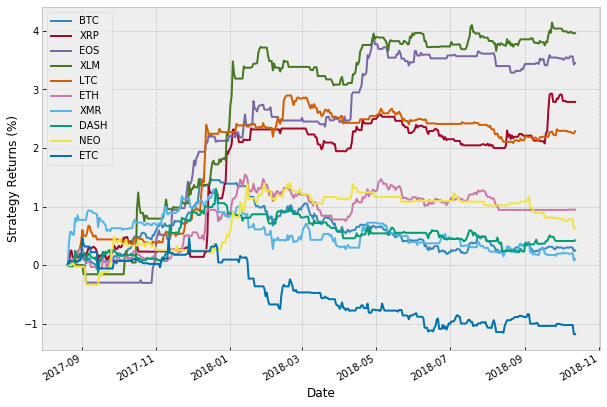

In [9]:
# Import matplotlib package to plot the graphs
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("bmh")

# Compute the strategy returns for each of the cryptocurrencies
strategy_returns = signal.shift(1) * df_pct

# Plot the cumulative sum of the returns for each of the cryptos
strategy_returns.cumsum().plot(figsize=(10, 7))
plt.xlabel('Date')
plt.ylabel('Strategy Returns (%)')
plt.show()

In the below code, the strategy returns are computed for all the cryptos and stored in daily_ret.

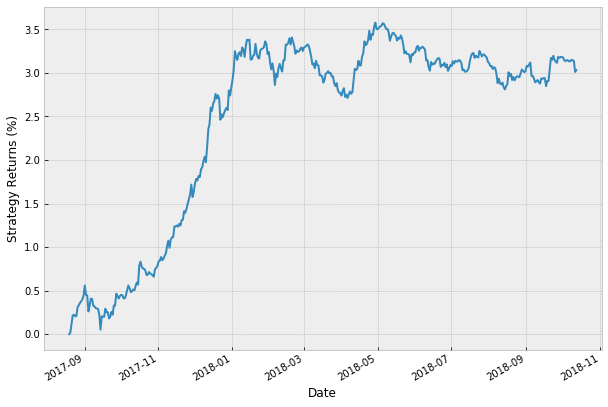

In [10]:
# Compute the strategy returns for all the cryptocurrencies in the portfolio.
# An equal weight is assumed for each of the cryptocurrency
# And therefore the strategy returns are divided by the number of positions
daily_ret = strategy_returns.sum(axis=1) / signal.sum(axis=1)

# Plot the cumulative strategy returns
daily_ret.cumsum().plot(figsize=(10, 7))
plt.xlabel('Date')
plt.ylabel('Strategy Returns (%)')
plt.show()

# Sharpe Ratio

In [11]:
import numpy as np

# The below function returns the Sharpe ratio for the excess returns ((Strategy returns) - (Risk-free rate)) passed to it.
def annualized_sharpe_ratio(returns, N=252):
    return np.sqrt(N) * returns.mean() / returns.std()

# Sharpe ratio
excess_daily_strategy_return = daily_ret - 0.05/252
sharpe = annualized_sharpe_ratio(excess_daily_strategy_return)
print('Sharpe', sharpe)

Sharpe 1.768056568636971


The strategy has a Sharpe ratio of 1.76. If you have an account with an exchange that allows you to short cryptos then you can modify the strategy to short the bottom 50% of the universe. This long-short strategy is expected to be more stable compared to the long-only strategy. <BR><BR>